In [22]:
import numpy as np
import sys
import os
import time
import copy
import datetime
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import argparse
import platform
import subprocess
from sklearn.metrics import roc_auc_score, average_precision_score
from social_data_loader import SocialEvolutionDataset
from github_data_loader import GithubDataset
from example_data_loader import ExampleDataset
from utils import *
from dyrep import DyRep
from freq import FreqBaseline

# Inside my model training code
import wandb
wandb.init(project="LDG-project")

def load_checkpoint(file):
    # TODO: Loading the checkpoint stopped working, need to fix.
    print('loading the model')
    state = torch.load(file)
    pos1 = file.find('checkpoint_dygraphs')
    experiment_ID = str.join('_', file[pos1:].split('_')[2:-2])
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    scheduler.load_state_dict(state['scheduler'])
    model.Lambda_dict = state['Lambda_dict']
    model.time_keys = state['time_keys']
    print('loading from epoch %d, batch %d done' % (state['epoch'], state['batch_idx']))
    return state['epoch'], state['batch_idx'], state['time_bar'], state['node_degree_global'], experiment_ID


def save_checkpoint(batch_idx, epoch):
    try:
        fname = f'{args.results}/checkpoints/checkpoint_dygraphs_{experiment_ID}_epoch{epoch}_batch{batch_idx}.pth.tar'
        wandb.save(f'checkpoints/checkpoint_dygraphs_{experiment_ID}_epoch{epoch}_batch{batch_idx}.pth.tar')
        print('saving the model to %s' % fname)
        state = {
            'epoch': epoch,
            'batch_idx': batch_idx,
            'args': args,
            'time_bar': time_bar,
            'node_degree_global': node_degree_global,
            'Lambda_dict': model.Lambda_dict,
            'time_keys': model.time_keys,
            'state_dict': model.state_dict(),
            'scheduler': scheduler.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        if os.path.isfile(fname):
            print('WARNING: file %s exists and will be overwritten' % fname)
        torch.save(state, fname)
    except Exception as e:
        print('error saving the model', e)


def test(model, n_test_batches=10):
    model.eval()
    loss = 0
    losses =[ [np.Inf, 0], [np.Inf, 0] ]
    n_samples = 0
    # Time slots with 10 days intervals as in the DyRep paper
    timeslots = [t.toordinal() for t in test_loader.dataset.TEST_TIMESLOTS]
    event_types = list(test_loader.dataset.event_types_num.keys()) #['comm', 'assoc']
    # sort it by k
    for event_t in test_loader.dataset.event_types_num:
        event_types[test_loader.dataset.event_types_num[event_t]] = event_t

    event_types += ['Com']

    mar, hits_10 = {}, {}
    for event_t in event_types:
        mar[event_t] = []
        hits_10[event_t] = []
        for c, slot in enumerate(timeslots):
            mar[event_t].append([])
            hits_10[event_t].append([])


    start = time.time()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data[2] = data[2].float().to(args.device)
            data[4] = data[4].double().to(args.device)
            data[5] = data[5].double()
            output = model(data)
            loss += (-torch.sum(torch.log(output[0]) + 1e-10) + torch.sum(output[1])).item()
            for i in range(len(losses)):
                m1 = output[i].min()
                m2 = output[i].max()
                if m1 < losses[i][0]:
                    losses[i][0] = m1
                if m2 > losses[i][1]:
                    losses[i][1] = m2
            n_samples += 1
            A_pred, Survival_term = output[2]
            u, v, k = data[0], data[1], data[3]

            time_cur = data[5]
            m, h = MAR(A_pred, u, v, k, Survival_term=Survival_term, freq_prior=freq.H_train_norm if args.freq else None)
            assert len(time_cur) == len(m) == len(h) == len(k)
            for t, m, h, k_ in zip(time_cur, m, h, k):
                d = datetime.datetime.fromtimestamp(t.item()).toordinal()
                event_t = event_types[k_.item()]
                for c, slot in enumerate(timeslots):
                    if d <= slot:
                        mar[event_t][c].append(m)
                        hits_10[event_t][c].append(h)
                        if k_ > 0:
                            mar['Com'][c].append(m)
                            hits_10['Com'][c].append(h)
                        if c > 0:
                            assert slot > timeslots[c-1] and d > timeslots[c-1], (d, slot, timeslots[c-1])
                        break

            if batch_idx % 10 == 0:
                print('test', batch_idx)

            if n_test_batches is not None and batch_idx >= n_test_batches - 1:
                break

    time_iter = time.time() - start

    print('\nTEST batch={}/{}, loss={:.3f}, psi={}, loss1 min/max={:.4f}/{:.4f}, '
          'loss2 min/max={:.4f}/{:.4f}, integral time stamps={}, sec/iter={:.4f}'.
          format(batch_idx + 1, len(test_loader), (loss / n_samples),
                 [model.psi[c].item() for c in range(len(model.psi))],
                 losses[0][0], losses[0][1], losses[1][0], losses[1][1],
                 len(model.Lambda_dict), time_iter / (batch_idx + 1)))

    # Report results for different time slots in the test set
    for c, slot in enumerate(timeslots):
        s = 'Slot {}: '.format(c)
        for event_t in event_types:
            sfx = '' if event_t == event_types[-1] else ', '
            if len(mar[event_t][c]) > 0:
                s += '{} ({} events): MAR={:.2f}+-{:.2f}, HITS_10={:.3f}+-{:.3f}'.\
                    format(event_t, len(mar[event_t][c]), np.mean(mar[event_t][c]), np.std(mar[event_t][c]),
                           np.mean(hits_10[event_t][c]), np.std(hits_10[event_t][c]))
            else:
                s += '{} (no events)'.format(event_t)
            s += sfx
        print(s)

    mar_all, hits_10_all = {}, {}
    for event_t in event_types:
        mar_all[event_t] = []
        hits_10_all[event_t] = []
        for c, slot in enumerate(timeslots):
            mar_all[event_t].extend(mar[event_t][c])
            hits_10_all[event_t].extend(hits_10[event_t][c])

    s = 'All slots: '
    for event_t in event_types:
        sfx = '' if event_t == event_types[-1] else ', '
        if len(mar_all[event_t]) > 0:
            s += '{} ({} events): MAR={:.2f}+-{:.2f}, HITS_10={:.3f}+-{:.3f}'.\
                format(event_t, len(mar_all[event_t]), np.mean(mar_all[event_t]), np.std(mar_all[event_t]),
                       np.mean(hits_10_all[event_t]), np.std(hits_10_all[event_t]))
        else:
            s += '{} (no events)'.format(event_t)
        s += sfx
    print(s)

    return mar_all, hits_10_all, loss / n_samples


def get_temporal_variables():
    variables = {}
    variables['time_bar'] = copy.deepcopy(time_bar)
    variables['node_degree_global'] = copy.deepcopy(node_degree_global)
    variables['time_keys'] = copy.deepcopy(model.time_keys)
    variables['z'] = model.z.clone()
    variables['S'] = model.S.clone()
    variables['A'] = model.A.clone()
    variables['Lambda_dict'] = model.Lambda_dict.clone()
    return variables


def set_temporal_variables(variables, model, train_loader, test_loader):
    time_bar = copy.deepcopy(variables['time_bar'])
    train_loader.dataset.time_bar = time_bar
    test_loader.dataset.time_bar = time_bar
    model.node_degree_global = copy.deepcopy(variables['node_degree_global'])
    model.time_keys = copy.deepcopy(variables['time_keys'])
    model.z = variables['z'].clone()
    model.S = variables['S'].clone()
    model.A = variables['A'].clone()
    model.Lambda_dict = variables['Lambda_dict'].clone()
    return time_bar

wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [25]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='DyGraphs Training Parameters')
    parser.add_argument('--data_dir', type=str, default='./')
    parser.add_argument('--dataset', type=str, default='social', choices=['social', 'github', 'example'])
    parser.add_argument('--prob', default=0.8,
                        help='filter events by this probability value in the Social Evolution data')
    parser.add_argument('--batch_size', type=int, default=200,
                        help='batch size (sequence length)')
    parser.add_argument('--n_hid', type=int, default=32,
                        help='hidden layer size')
    parser.add_argument('--epochs', type=int, default=5,
                        help='number of epochs')
    parser.add_argument('--seed', type=int, default=1111,
                        help='random seed')
    parser.add_argument('--lr', type=float, default=0.0002,
                        help='Learning Rate')
    parser.add_argument('--lr_decay_step', type=str, default='10',
                        help='number of epochs after which to reduce learning rate')
    parser.add_argument('--weight', type=float, default=1,
                        help='weight for the second term in the loss')
    parser.add_argument('--wdecay', type=float, default=0,
                        help='weight decay')
    parser.add_argument('--bilinear', action='store_true', default=False,
                        help='use bilinear model')
    parser.add_argument('--encoder', type=str, default=None, choices=['linear', 'mlp', 'mlp1', 'rand'])
    parser.add_argument('--sparse', action='store_true', default=False,
                        help='sparsity prior as in some tasks in Kipf et al., ICML 2018')
    parser.add_argument('--n_rel', type=int, default=2,
                        help='number of edges for learned graphs')
    parser.add_argument('--device', type=str, default='cpu')
    parser.add_argument('--association', type=str, default='CloseFriend',
                        help='The long term graph of the Social Evolution data used as long term edges')
    parser.add_argument('--resume', type=str, default='')
    parser.add_argument('--log_interval', type=int, default=20,
                        help='print interval')
    parser.add_argument('--results', type=str, default='results',
                        help='results file path')
    parser.add_argument('--soft_attn', action='store_true', default=False)
    parser.add_argument('--freq', action='store_true', default=False,
                        help='use the Frequency bias')

In [30]:
    dyrep_social = "--log_interval 300 --epochs 5 --data_dir ./SocialEvolution/"
    # dyrep_github = "--log_interval 300 --epochs 5 --dataset github --data_dir ./Github"
    # ldg_social = "--log_interval 300  --data_dir ./SocialEvolution/ --encoder mlp --soft_attn --bilinear --sparse"
    # ldg_github = "--log_interval 300  --dataset github --data_dir ./Github --encoder mlp --soft_attn --bilinear --sparse"
    args = parser.parse_args(dyrep_social.split())
    
    args.lr_decay_step = list(map(int, args.lr_decay_step.split(',')))
    args.torch = torch.__version__
    for arg in vars(args):
        print(arg, getattr(args, arg))

    dt = datetime.datetime.now()
    print('start time:', dt)
    experiment_ID = '%s_%06d' % (platform.node(), dt.microsecond)
    print('experiment_ID: ', experiment_ID)

    try:
        gitcommit = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip()
        print('gitcommit', gitcommit)
    except Exception as e:
        print('gitcommit is not available', e)

data_dir ./SocialEvolution/
dataset social
prob 0.8
batch_size 200
n_hid 32
epochs 5
seed 1111
lr 0.0002
lr_decay_step [10]
weight 1
wdecay 0
bilinear False
encoder None
sparse False
n_rel 2
device cpu
association CloseFriend
resume 
log_interval 300
results results
soft_attn False
freq False
torch 1.4.0
start time: 2020-03-22 22:17:20.102635
experiment_ID:  gimtaehcBookPro.fios-router.home_102635
gitcommit 273d809


In [31]:
    # Set seed
    np.random.seed(args.seed)
    rnd = np.random.RandomState(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    # TODO: 1. 데이터를 불러온다.
    if args.dataset == 'social':
        data = SocialEvolutionDataset.load_data(args.data_dir, args.prob)
        train_set = SocialEvolutionDataset(data['initial_embeddings'], data['train'], args.association)
        test_set = SocialEvolutionDataset(data['initial_embeddings'], data['test'], args.association,
                                    data_train=data['train'])
        initial_embeddings = data['initial_embeddings'].copy()
        A_initial = train_set.get_Adjacency()[0]

    elif args.dataset == 'github':
        train_set = GithubDataset('train', data_dir=args.data_dir)
        test_set = GithubDataset('test', data_dir=args.data_dir)
        initial_embeddings = np.random.randn(train_set.N_nodes, args.n_hid)
        A_initial = train_set.get_Adjacency()[0]

    elif args.dataset == 'example':
        train_set = ExampleDataset('train')
        test_set = ExampleDataset('test')
        initial_embeddings = np.random.randn(train_set.N_nodes, args.n_hid)
        A_initial = train_set.get_Adjacency()[0]

    else:
        raise NotImplementedError(args.dataset)

    def initalize_state(dataset, keepS=False):
        '''
        Initializes node embeddings and the graph to the original state after every epoch
        Adjacency로부터 Node별 Degree를 계산하고, time_bar도 초기화 한다.
        :param dataset: Train 데이터셋
        :param keepS: True(LDG논문)이면 S를 데이터로부터 예측하게 되고, False(DyREP논문)이면 A로부터 계산한다.
        :return:
            time_bar: 모든 노드별 바로 이전 이벤트 시간 (초기화값으로 FIRST_TIME이 된다.)
            node_degree_global: 노드별 Degree값을 저장
        '''

        Adj_all = dataset.get_Adjacency()[0]

        if not isinstance(Adj_all, list):
            Adj_all = [Adj_all]

        #각 관계타입 및 노드 별로 Degree값을 계산한다.
        node_degree_global = []
        for rel, A in enumerate(Adj_all):
            node_degree_global.append(np.zeros(A.shape[0]))
            for u in range(A.shape[0]):
                node_degree_global[rel][u] = np.sum(A[u])

        Adj_all = Adj_all[0]    #첫번째 Relation만 쓰겠다는 의미.
        print('Adj_all', Adj_all.shape, len(node_degree_global), node_degree_global[0].min(), node_degree_global[0].max())
        time_bar = np.zeros((dataset.N_nodes, 1)) + dataset.FIRST_DATE.timestamp()

        model.initialize(node_embeddings=initial_embeddings,
                         A_initial=Adj_all, keepS=keepS)  # train_loader.dataset.H_train


        model.to(args.device)
        return time_bar, node_degree_global

loading data from ./SocialEvolution/data_prob0.8.pkl
SMS 1 4319
Proximity 2 31011
Calls 3 8187
{'Proximity', 'Calls', 'SMS'}
initial and final associations CloseFriend 575.0 708.0 False
train CloseFriend 365
{'CloseFriend', 'Proximity', 'Calls', 'SMS'}
43834 events
last 10 events:
(0, 60, 'Proximity', datetime.datetime(2009, 4, 30, 23, 37, 5))
(60, 0, 'Proximity', datetime.datetime(2009, 4, 30, 23, 37, 32))
(0, 60, 'Proximity', datetime.datetime(2009, 4, 30, 23, 42, 22))
(60, 0, 'Proximity', datetime.datetime(2009, 4, 30, 23, 42, 47))
(0, 60, 'Proximity', datetime.datetime(2009, 4, 30, 23, 47, 39))
(60, 0, 'Proximity', datetime.datetime(2009, 4, 30, 23, 48, 3))
(0, 60, 'Proximity', datetime.datetime(2009, 4, 30, 23, 52, 56))
(60, 0, 'Proximity', datetime.datetime(2009, 4, 30, 23, 53, 19))
(0, 60, 'Proximity', datetime.datetime(2009, 4, 30, 23, 58, 13))
(60, 0, 'Proximity', datetime.datetime(2009, 4, 30, 23, 58, 35))
H_train 43834, 11731.0, 0.0, 241.63652752740037
SMS 1 288
Proximity 2 

## 데이터 전처리: 각 이벤트 별로 Inter-event time의 Distribution을 확인하고자 함
- all_event에서 데이터를 가져와서 (U1, U2, Event, Time)으로 저장하고,
- 각 사용자 pair 및 이벤트 별로 Inter-event time의 Distribution을 plotting 해본다.

In [241]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [242]:
df = pd.DataFrame(train_set.all_events)
df = df.rename(columns={0: "u1", 1: "u2", 2:"event", 3:"time"})

user1_list = list(set(df.u1))
user2_list = list(set(df.u2))
event_list = list(set(df.event))

df.head()

,u1,u2,event,time
0,42,50,Calls,2008-09-11 03:16:14
1,42,50,Calls,2008-09-19 00:31:33
2,42,21,Calls,2008-09-19 00:58:02
3,42,54,Calls,2008-09-19 01:21:04
4,42,50,Calls,2008-09-19 18:20:43


In [243]:
dff = df.groupby(['u1','u2','event'], as_index=False)['u1','u2','event', 'time'].agg(lambda x: list(x))
dff['timediff_s'] = [[] for _ in range(len(dff))]
dff['timediff_m'] = [[] for _ in range(len(dff))]
dff['timediff_h'] = [[] for _ in range(len(dff))]
dff['timediff_d'] = [[] for _ in range(len(dff))]

data_len = dff.shape[0]
times = dff.iloc[1].time

for i in range(data_len):
    len_times = len(dff.iloc[i].time)
    times = dff.iloc[i].time
    if(len_times == 1):
        dff.timediff_s.iloc[i].append(0)
        dff.timediff_m.iloc[i].append(0)
        dff.timediff_h.iloc[i].append(0)
        dff.timediff_d.iloc[i].append(0)
    else:
        for j in range(len_times - 1):
            dff.timediff_s.iloc[i].append(int((times[j+1] - times[j]) / np.timedelta64(1, 's')))
            dff.timediff_m.iloc[i].append(int((times[j+1] - times[j]) / np.timedelta64(1, 'm')))
            dff.timediff_h.iloc[i].append(int((times[j+1] - times[j]) / np.timedelta64(1, 'h')))
            dff.timediff_d.iloc[i].append(times[j+1].toordinal() - times[j].toordinal())

dff.head()

,u1,u2,event,time,timediff_s,timediff_m,timediff_h,timediff_d
0,0,27,CloseFriend,"[2008-10-19 00:00:00, 2009-04-17 00:00:00]",[15552000],[259200],[4320],[180]
1,0,36,Calls,"[2008-10-09 00:56:40, 2008-12-29 19:12:04, 200...","[7064124, 19472]","[117735, 324]","[1962, 5]","[81, 1]"
2,0,36,SMS,"[2009-02-05 19:29:00, 2009-02-05 19:39:44, 200...","[644, 2956, 4244, 2954, 2, 644, 2956, 6977574,...","[10, 49, 70, 49, 0, 10, 49, 116292, 2, 3, 0, 2]","[0, 0, 1, 0, 0, 0, 0, 1938, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0]"
3,0,60,Calls,"[2008-10-02 21:51:40, 2008-10-03 19:10:18, 200...","[76718, 35364, 32868, 13636, 1557, 5800, 3719,...","[1278, 589, 547, 227, 25, 96, 61, 24, 18, 144,...","[21, 9, 9, 3, 0, 1, 1, 0, 0, 2, 0, 0, 11, 1, 7...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,0,60,Proximity,"[2008-10-07 09:43:16, 2008-10-08 00:08:31, 200...","[51915, 343, 311, 8580412, 89383, 339, 212767,...","[865, 5, 5, 143006, 1489, 5, 3546, 2154, 5034,...","[14, 0, 0, 2383, 24, 0, 59, 35, 83, 0, 2, 0, 0...","[1, 0, 0, 99, 1, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0,..."


In [337]:
dff.head()

,u1,u2,event,time,timediff_s,timediff_m,timediff_h,timediff_d
0,0,27,CloseFriend,"[2008-10-19 00:00:00, 2009-04-17 00:00:00]",[15552000],[259200],[4320],[180]
1,0,36,Calls,"[2008-10-09 00:56:40, 2008-12-29 19:12:04, 200...","[7064124, 19472]","[117735, 324]","[1962, 5]","[81, 1]"
2,0,36,SMS,"[2009-02-05 19:29:00, 2009-02-05 19:39:44, 200...","[644, 2956, 4244, 2954, 2, 644, 2956, 6977574,...","[10, 49, 70, 49, 0, 10, 49, 116292, 2, 3, 0, 2]","[0, 0, 1, 0, 0, 0, 0, 1938, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0, 0]"
3,0,60,Calls,"[2008-10-02 21:51:40, 2008-10-03 19:10:18, 200...","[76718, 35364, 32868, 13636, 1557, 5800, 3719,...","[1278, 589, 547, 227, 25, 96, 61, 24, 18, 144,...","[21, 9, 9, 3, 0, 1, 1, 0, 0, 2, 0, 0, 11, 1, 7...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,0,60,Proximity,"[2008-10-07 09:43:16, 2008-10-08 00:08:31, 200...","[51915, 343, 311, 8580412, 89383, 339, 212767,...","[865, 5, 5, 143006, 1489, 5, 3546, 2154, 5034,...","[14, 0, 0, 2383, 24, 0, 59, 35, 83, 0, 2, 0, 0...","[1, 0, 0, 99, 1, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0,..."


In [308]:
flatten = lambda l: [item for sublist in l for item in sublist]
dff_s = dff.groupby(['u1','u2','event'])['u1','u2','event','timediff_s'].agg(flatten)
dff_m = dff.groupby(['u1','u2','event'])['u1','u2','event','timediff_m'].agg(flatten)
dff_h = dff.groupby(['u1','u2','event'])['u1','u2','event','timediff_h'].agg(flatten)
dff_d = dff.groupby(['u1','u2','event'])['u1','u2','event','timediff_d'].agg(flatten)

In [328]:
dff_s.head()

timediff_s
u1 u2 event                                                         
0  27 CloseFriend                                         [15552000]
   36 Calls                                         [7064124, 19472]
      SMS          [644, 2956, 4244, 2954, 2, 644, 2956, 6977574,...
   60 Calls        [76718, 35364, 32868, 13636, 1557, 5800, 3719,...
      Proximity    [51915, 343, 311, 8580412, 89383, 339, 212767,...

In [280]:
dff_s_all = dff_s.groupby(['event'])['timediff_s'].agg(flatten)
dff_m_all = dff_m.groupby(['event'])['timediff_m'].agg(flatten)
dff_h_all = dff_h.groupby(['event'])['timediff_h'].agg(flatten)
dff_d_all = dff_d.groupby(['event'])['timediff_d'].agg(flatten)

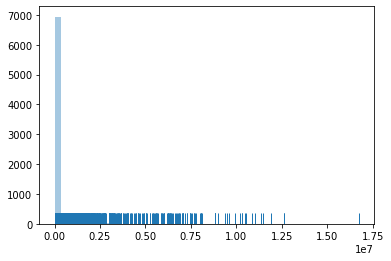

In [288]:
x = dff_s_all['Calls']
sns.distplot(x, kde=False, rug=True);

In [360]:
dff_s_all = dff_s.reset_index()

In [361]:
dff_s_all.head()

,u1,u2,event,timediff_s
0,0,27,CloseFriend,[15552000]
1,0,36,Calls,"[7064124, 19472]"
2,0,36,SMS,"[644, 2956, 4244, 2954, 2, 644, 2956, 6977574,..."
3,0,60,Calls,"[76718, 35364, 32868, 13636, 1557, 5800, 3719,..."
4,0,60,Proximity,"[51915, 343, 311, 8580412, 89383, 339, 212767,..."


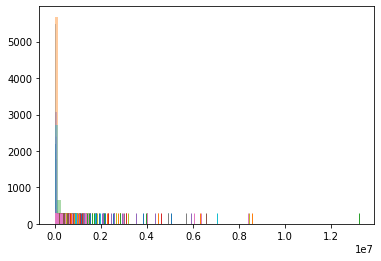

In [372]:
for i in dff_s_all.timediff_s.values:
    if len(i) >= 50:
        sns.distplot(i, kde=False, rug=True);

## 끝

In [ ]:
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

    if args.freq:
        freq = FreqBaseline(train_set, test_set)

    # TODO: 2. Model을 정의한다. (이때 __init__이 수행할때, GNN의 Hidden Embedding(Z)와 A로부터 S를 계산해 초기화한다) ,
    model = DyRep(node_embeddings=initial_embeddings,
                  N_nodes=train_set.N_nodes,
                  A_initial=A_initial,
                  n_hidden=args.n_hid,
                  bilinear=args.bilinear,
                  sparse=args.sparse,
                  encoder=args.encoder,
                  n_rel=args.n_rel,
                  rnd=rnd,
                  soft_attn=args.soft_attn,
                  freq=freq.H_train_norm if args.freq else None,    #Frequency Baseline을 Bias로 활용할 것인지!?
                  node_degree_global=None).to(args.device)

    print(model)
    #만약 모델 파라미터가 Gradient 계산이 필요하면, 그의 사이즈를 모두 곱(np.prod)하여 리스트에 저장함. 모두 계산되면 합한다 (np.sum)
    print('number of training parameters: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

    # TODO: 3. Optimizer를 설정한다.
    params_main, params_enc = [], []
    for name, param in model.named_parameters():
        if name.find('encoder') >= 0 and param.requires_grad:
            params_enc.append(param)
        elif param.requires_grad:
            params_main.append(param)

    #각 parameter별로 서로 다른 weight_decay를 주기 위함
    optimizer = optim.Adam([{"params": params_main, "weight_decay": args.wdecay},
                            {"params": params_enc, "weight_decay": 1e-4}],
                           lr=args.lr,
                           betas=(0.5, 0.999))
    scheduler = lr_scheduler.MultiStepLR(optimizer, args.lr_decay_step, gamma=0.5)

    if args.resume != '':   #재시작인 경우, 저장했던 것부터 다시 시작
        epoch_start, batch_start, time_bar, node_degree_global, experiment_ID = load_checkpoint(args.resume)
        resume = True
        model.node_degree_global = node_degree_global
    else:
        epoch_start = 1
        batch_start = 0
        resume = False


    # TODO: 4. Loss를 저장할 변수를 정의한다.
    losses_events, losses_nonevents, losses_KL, losses_sum = [], [], [], []
    test_MAR, test_HITS10, test_loss = [], [], []

    # TODO: 5. 학습: Epoch만큼 학습을 한다.
    for epoch in range(epoch_start, args.epochs + 1):

        # scheduler.step()
        # TODO: 5.1. 재시작이 아니거나, 처음이 아니면, 초기화 해준다. (재시작이거나, 처음인 경우 model=DyREP()하면서 초기화 되어 있으므로)
        if (not resume) or (epoch != epoch_start):        # if not (resume and epoch == epoch_start):
            # Reinitialize node embeddings and adjacency matrices, but keep the model parameters intact
            time_bar, node_degree_global = initalize_state(train_loader.dataset, keepS=epoch > 1)
            model.node_degree_global = node_degree_global

        train_loader.dataset.time_bar = time_bar
        test_loader.dataset.time_bar = time_bar

        start = time.time()

        # TODO: 5.2. 학습데이터의 배치를 하나씩 가져와서 예측/Loss계산/Optimizer 돌린다.
        for batch_idx, data_batch in enumerate(train_loader):

            if resume and batch_idx <= batch_start: ##kingmbc: 재시작이고, batch_idx가 이미 예전에 학습한 배치이면, pass
                continue
            model.train()

            optimizer.zero_grad()
            #data_batch[0]과 data_batch[1]은 해당 이벤트의 두 노드(u, v)를 의미
            data_batch[2] = data_batch[2].float().to(args.device)       #kingmbc: time_delta_uv (u,v 각 노드의 자신의 이전 이벤트와의 시간차) [2x4]
            data_batch[4] = data_batch[4].double().to(args.device)      #kingmbc: time_bar      (모든 노드에 대한 이전 시간)
            data_batch[5] = data_batch[5].double()  # no need of GPU    #kingmbc: time_cur      (현재 시간)
            output = model(data_batch)
            losses = [-torch.sum(torch.log(output[0]) + 1e-10), args.weight * torch.sum(output[1])]  #

            # KL losses (one item per event)
            if len(output[-1]) > 0:
                losses.extend(output[-1])
                losses_KL.append(torch.stack(losses[2:]).sum().item())

            loss = torch.sum(torch.stack(losses)) / args.batch_size
            loss.backward()
            wandb.log({'epoch': epoch, 'loss': loss})
            nn.utils.clip_grad_value_(model.parameters(), 100)

            optimizer.step()

            losses_events.append(losses[0].item())
            losses_nonevents.append(losses[1].item())
            losses_sum.append(loss.item())

            assert np.allclose(train_loader.dataset.time_bar, time_bar)
            assert np.allclose(test_loader.dataset.time_bar, time_bar)


            #https://pytorch.org/docs/stable/torch.html#torch.clamp
            #model.psi.data를 min=1e-1(0.1)과 max=1e+3(1000)사이로 묶는다.
            model.psi.data = torch.clamp(model.psi.data, 1e-1, 1e+3)  # to prevent overflow in computing Lambda

            time_iter = time.time() - start

            model.z = model.z.detach()  # to reset the computational graph and avoid backpropagating second time
            model.S = model.S.detach()

            if (batch_idx + 1) % args.log_interval == 0 or batch_idx == len(train_loader) - 1:
                # Report (intermediate) results

                print(f'\nTRAIN epoch={epoch}/{args.epochs}, batch={batch_idx + 1}/{len(train_loader)},'
                      f' sec/iter: {time_iter / (batch_idx + 1):.4f},'
                      f' loss={loss.item():.3f}, loss components: {[l.item() for l in losses]}')

                if args.encoder is not None:
                    S = model.S.data.cpu().numpy()
                    S_batch = output[3].sum(axis=0)
                    A_all_first, keys, A_all_last = train_loader.dataset.get_Adjacency(multirelations=True)

                    for survey, A_all in zip(['first', 'last'], [A_all_first, A_all_last]):
                        for rel, key in enumerate(keys):
                            if len(A_all.shape) == 2:
                                A_all = A_all[:, :, None]

                            A = A_all[:, :, rel].flatten()
                            for edge_type in range(S.shape[2]):
                                prec = average_precision_score(y_true=A, y_score=S[:, :, edge_type].flatten())
                                acc = np.mean(np.equal(A, (S[:, :, edge_type].flatten() > 0).astype(np.float)))
                                auc = roc_auc_score(y_true=A, y_score=S[:, :, edge_type].flatten())
                                c = np.corrcoef(A.flatten(), S[:, :, edge_type].flatten())[0, 1]

                                prec_batch = average_precision_score(y_true=A, y_score=S_batch[:, :, edge_type].flatten())
                                acc_batch = np.mean(np.equal(A, (S_batch[:, :, edge_type].flatten() > 0).astype(np.float)))
                                auc_batch = roc_auc_score(y_true=A, y_score=S_batch[:, :, edge_type].flatten())
                                c_batch = np.corrcoef(A.flatten(), S_batch[:, :, edge_type].flatten())[0, 1]

                                print('{}: Edge {} with {}: acc={:.4f}, auc={:.4f}, prec={:.4f}, corr={:.4f}, '
                                      'acc_batch={:.4f}, auc_batch={:.4f}, prec_batch={:.4f}, corr_batch={:.4f}'.
                                      format(survey, edge_type, key, acc, auc, prec, c,
                                             acc_batch, auc_batch, prec_batch, c_batch))

                    for edge_type in range(S.shape[2]):
                        c = np.corrcoef(freq.H_train.flatten(), S[:, :, edge_type].flatten())[0, 1]
                        c_batch = np.corrcoef(freq.H_train.flatten(), S_batch[:, :, edge_type].flatten())[0, 1]
                        print('Edge {} with H_train: corr={:.4f}, corr_batch={:.4f}'.format(edge_type, c, c_batch))


                # save node embeddings and other data before testing since these variables will be updated during testing
                variables = get_temporal_variables()
                print('time', datetime.datetime.fromtimestamp(np.max(time_bar)))

                result = test(model, n_test_batches=None if batch_idx == len(train_loader) - 1 else 10)
                test_MAR.append(np.mean(result[0]['Com']))
                test_HITS10.append(np.mean(result[1]['Com']))
                test_loss.append(result[2])
                save_checkpoint(batch_idx + 1, epoch)

                # restore node embeddings and other data
                time_bar = set_temporal_variables(variables, model, train_loader, test_loader)

        scheduler.step()

    print('end time:', datetime.datetime.now())